Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train_outputs_cnn shape: (85608,)
val_outputs_cnn shape: (18286,)
train_outputs_fc shape: (21084, 1)
val_outputs_fc shape: (5271, 1)
train_targets_cnn shape: (85608,)
val_targets_cnn shape: (18286,)
train_targets_fc shape: (21084, 1)
val_targets_fc shape: (5271, 1)
train_targets_combined shape: (106692, 1)
val_targets_combined shape: (23557, 1)
train_outputs_combined shape: (106692, 1)
val_outputs_combined shape: (23557, 1)
Modelo guardado después de la época 1.
Época 1/150, Pérdida Entrenamiento: 0.6063, Pérdida Validación: 0.5874, R2 Entrenamiento: -0.1279, R2 Validación: -0.0663
Modelo guardado después de la época 2.
Época 2/150, Pérdida Entrenamiento: 0.5823, Pérdida Validación: 0.5905, R2 Entrenamiento: -0.0833, R2 Validación: -0.0720
Modelo guardado después de la época 3.
Época 3/150, Pérdida Entrenamiento: 0.5675, Pérdida Validación: 0.5927, R2 Entrena

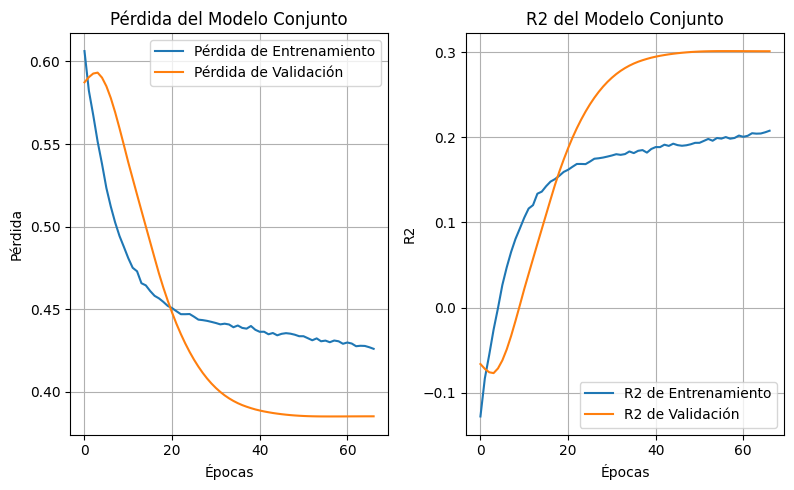

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# los archivos de salida y targets
train_outputs_cnn = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/train_outputs_cnn.npy')
val_outputs_cnn = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/val_outputs_cnn.npy')
train_outputs_fc = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/train_outputs_fc.npy')
val_outputs_fc = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/val_outputs_fc.npy')
train_targets_cnn = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/train_targets_cnn.npy')
val_targets_cnn = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/val_targets_cnn.npy')
train_targets_fc = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/train_targets_fc.npy')
val_targets_fc = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/val_targets_fc.npy')

# Verificar dimensiones
print(f"train_outputs_cnn shape: {train_outputs_cnn.shape}")
print(f"val_outputs_cnn shape: {val_outputs_cnn.shape}")
print(f"train_outputs_fc shape: {train_outputs_fc.shape}")
print(f"val_outputs_fc shape: {val_outputs_fc.shape}")
print(f"train_targets_cnn shape: {train_targets_cnn.shape}")
print(f"val_targets_cnn shape: {val_targets_cnn.shape}")
print(f"train_targets_fc shape: {train_targets_fc.shape}")
print(f"val_targets_fc shape: {val_targets_fc.shape}")

# Para que todos tengan forma (n, 1)
train_targets_cnn = train_targets_cnn.reshape(-1, 1)
train_targets_fc = train_targets_fc.reshape(-1, 1)
val_targets_cnn = val_targets_cnn.reshape(-1, 1)
val_targets_fc = val_targets_fc.reshape(-1, 1)
train_outputs_cnn = train_outputs_cnn.reshape(-1, 1)
val_outputs_cnn = val_outputs_cnn.reshape(-1, 1)
train_outputs_fc = train_outputs_fc.reshape(-1, 1)
val_outputs_fc = val_outputs_fc.reshape(-1, 1)

# Concatenar las salidas y los targets
train_targets_combined = np.concatenate((train_targets_cnn, train_targets_fc), axis=0)
val_targets_combined = np.concatenate((val_targets_cnn, val_targets_fc), axis=0)
train_outputs_combined = np.concatenate((train_outputs_cnn, train_outputs_fc), axis=0)
val_outputs_combined = np.concatenate((val_outputs_cnn, val_outputs_fc), axis=0)

# Verificar las formas
print("train_targets_combined shape:", train_targets_combined.shape)
print("val_targets_combined shape:", val_targets_combined.shape)
print("train_outputs_combined shape:", train_outputs_combined.shape)
print("val_outputs_combined shape:", val_outputs_combined.shape)

# Convertir a tensores
train_outputs_tensor = torch.tensor(train_outputs_combined, dtype=torch.float32)
val_outputs_tensor = torch.tensor(val_outputs_combined, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets_combined, dtype=torch.float32)
val_targets_tensor = torch.tensor(val_targets_combined, dtype=torch.float32)

# Mover a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_outputs_tensor = train_outputs_tensor.to(device)
val_outputs_tensor = val_outputs_tensor.to(device)
train_targets_tensor = train_targets_tensor.to(device)
val_targets_tensor = val_targets_tensor.to(device)

# Definir el modelo conjunto
class EnsembleModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(EnsembleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.tanh(self.fc3(x))
        return x


input_size = train_outputs_combined.shape[1]
hidden_size1 = 32
hidden_size2 = 16
output_size = 1

# Instanciar el modelo y moverlo a GPU
ensemble_model = EnsembleModel(input_size, hidden_size1, hidden_size2, output_size).to(device)

# la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

# Early Stopping
patience = 10
best_val_loss = float('inf')
patience_counter = 0

# Entrenamiento
epochs = 150
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

for epoch in range(epochs):
    ensemble_model.train()
    optimizer.zero_grad()
    outputs = ensemble_model(train_outputs_tensor)
    loss = criterion(outputs, train_targets_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calcular R2
    train_r2 = r2_score(train_targets_tensor.cpu().detach().numpy(), outputs.cpu().detach().numpy())
    train_r2_scores.append(train_r2)

    # Validación
    ensemble_model.eval()
    with torch.no_grad():
        val_outputs = ensemble_model(val_outputs_tensor)
        val_loss = criterion(val_outputs, val_targets_tensor)
        val_losses.append(val_loss.item())
        val_r2 = r2_score(val_targets_tensor.cpu().detach().numpy(), val_outputs.cpu().detach().numpy())
        val_r2_scores.append(val_r2)

    # Early Stopping:
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping activado en la época {epoch+1}. No hubo mejora en la pérdida de validación durante {patience} épocas.")
        break

    # Guardar el modelo
    torch.save({
        'epoch': epoch,
        'model_state_dict': ensemble_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_r2': train_r2_scores,
        'val_r2': val_r2_scores
    }, '/content/drive/My Drive/Colab Notebooks/Proyecto/ensemble_model.pth')

    print(f"Modelo guardado después de la época {epoch+1}.")

    # Imprimir las pérdidas y R2
    print(f"Época {epoch+1}/{epochs}, Pérdida Entrenamiento: {loss.item():.4f}, "
          f"Pérdida Validación: {val_loss.item():.4f}, "
          f"R2 Entrenamiento: {train_r2:.4f}, R2 Validación: {val_r2:.4f}")

# Graficar las pérdidas y R2
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida del Modelo Conjunto')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(train_r2_scores, label='R2 de Entrenamiento')
plt.plot(val_r2_scores, label='R2 de Validación')
plt.xlabel('Épocas')
plt.ylabel('R2')
plt.title('R2 del Modelo Conjunto')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [21]:
# los archivos de salida y targets de prueba
test_outputs_cnn = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/test_outputs_cnn.npy')
test_outputs_fc = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/test_outputs_fc.npy')
test_targets_cnn = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/test_targets_cnn.npy')
test_targets_fc = np.load('/content/drive/My Drive/Colab Notebooks/Proyecto/test_targets_fc.npy')

# Para que todos los targets tengan forma (n, 1)
test_targets_cnn = test_targets_cnn.reshape(-1, 1)
test_targets_fc = test_targets_fc.reshape(-1, 1)
test_outputs_cnn = test_outputs_cnn.reshape(-1, 1)
test_outputs_fc = test_outputs_fc.reshape(-1, 1)

# Concatenar las salidas y los targets de prueba
test_targets_combined = np.concatenate((test_targets_cnn, test_targets_fc), axis=0)
test_outputs_combined = np.concatenate((test_outputs_cnn, test_outputs_fc), axis=0)

# Verificar las formas
print("test_targets_combined shape:", test_targets_combined.shape)
print("test_outputs_combined shape:", test_outputs_combined.shape)

# Convertir a tensores
test_outputs_tensor = torch.tensor(test_outputs_combined, dtype=torch.float32)
test_targets_tensor = torch.tensor(test_targets_combined, dtype=torch.float32)

# Mover a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_outputs_tensor = test_outputs_tensor.to(device)
test_targets_tensor = test_targets_tensor.to(device)

# Cargar el modelo conjunto entrenado
ensemble_model = EnsembleModel(input_size=test_outputs_combined.shape[1],
                               hidden_size1=32, hidden_size2=16, output_size=1).to(device)

checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/Proyecto/ensemble_model.pth')
ensemble_model.load_state_dict(checkpoint['model_state_dict'])
ensemble_model.eval()  #  modo evaluación

# Evaluación en el conjunto de prueba
with torch.no_grad():
    test_outputs = ensemble_model(test_outputs_tensor)
    test_loss = criterion(test_outputs, test_targets_tensor)

    # Calcular R2 de prueba
    test_r2 = r2_score(test_targets_tensor.cpu().detach().numpy(), test_outputs.cpu().detach().numpy())

    print(f"Pérdida en el conjunto de prueba: {test_loss.item():.4f}")
    print(f"R2 en el conjunto de prueba: {test_r2:.4f}")





test_targets_combined shape: (539, 1)
test_outputs_combined shape: (539, 1)
Pérdida en el conjunto de prueba: 0.3235
R² en el conjunto de prueba: 0.3887


<ipython-input-21-ff1552bd17b9>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/Proyecto/ensemble_model.pt